# Model Building: AQI Forecast for the Next 1 Day

The core feature and process of the product are as below:
- The core feature is “global urban air quality prediction”.
- For US cities, use 2 publicly available scientific datasets as source: 1) National Oceanic and Atmospheric Administration: Global Surface Summary of the Day, 2) OpenAQ. You can get detailed information from “Concepts and knowledge” section.
- Use multiple machine learning (ML) models to prediction. You can get detailed information from “Concepts and knowledge” section.
- The output of the model is "AQI Forecast for the next 1 days, 24-hour scale". For US Cities, follow U.S.AQI definition set by U.S. Environmental Protection Agency (Hereafter referred to as EPA). You can get detailed information from “Concepts and knowledge” section.
- There are two types of end users: enterprise and individual.
- Data scientists are responsible for the datasets and models.
- The R&D team is responsible for the front and back ends.
- The content for individual End-User is a picture that reflects the characteristics of the city, the theme of the day, AQI information and health information.

In [8]:
import os
import io
import numpy as np
import pandas as pd
import math
import csv
import gzip
import boto3
import matplotlib.pyplot as plt
from io import StringIO
from botocore import UNSIGNED
from botocore.config import Config
from botocore.exceptions import ClientError
from autogluon.timeseries import TimeSeriesPredictor
from autogluon.timeseries.dataset.ts_dataframe import TimeSeriesDataFrame

## 1. 构建数据集

按照 Asssignment 要求，从两个数据源获取训练数据构建数据集，步骤包括：
- 1.1 数据采集
- 1.2 数据合并
- 1.3 数据清洗
- 1.4 数据集成

### 1.1 数据采集
鉴于 NOAA GSOD 和 OpenAQ 是两份完全不同的数据集，需要将两份数据合并才能构建完整的 dataset. 面临的问题：
- 两个数据集对于同一地址（数据采集站点）的编号不相同。
- NOAA GSOD 每天一条、OpenAQ 每小时每种污染物一条。
- OpenAQ 从2016年开始才有数据，且部分数据缺失严重。
- OpenAQ API V2 版本不能使用，V3版本需要身份验证。
- OpenAQ 用于身份验证的网站 [explorer.openaq.org](https://explore.openaq.org/) 无法使用。
- 意味着无法使用 OpenAQ API，不能自动匹配出两个数据集对同一地址的编号。

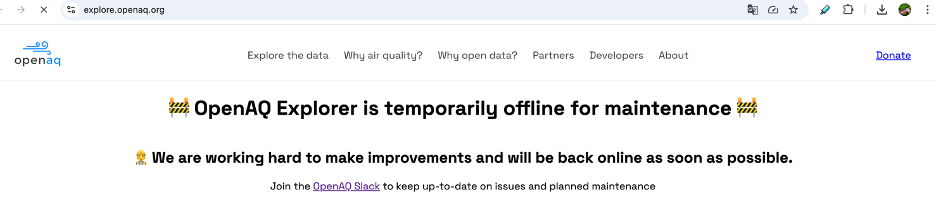

使用迂回测试的办法，在确保 OpenAQ 有数据的前提下，迂回获取数据，思路如下：
- 查看 OpenAQ 中某个 location id 下是否有完整数据
- 取到一份数据后，查看其 经纬度
- 根据 经纬度 反查出所在的 城市名
- 根据 城市名 到 NOAA 中查 站点编号
- 根据 站点编号 取一份数据，确认 经纬度 是否相符

#### （a）获取 OpenAQ 有效数据 location 的经纬度

In [484]:
!aws s3 ls --no-sign-request s3://openaq-data-archive/records/csv.gz/locationid=2064/year=2019/month=03/

2023-11-09 12:50:49        248 location-2064-20190301.csv.gz
2023-11-09 13:06:25        245 location-2064-20190302.csv.gz
2023-11-09 13:06:34        236 location-2064-20190303.csv.gz
2023-11-09 12:50:13        228 location-2064-20190304.csv.gz
2023-11-09 12:50:01        252 location-2064-20190305.csv.gz
2023-11-09 12:34:42        244 location-2064-20190306.csv.gz
2023-11-09 13:05:48        250 location-2064-20190307.csv.gz
2023-11-09 13:06:13        257 location-2064-20190308.csv.gz
2023-11-09 13:21:32        261 location-2064-20190309.csv.gz
2023-11-09 13:06:46        184 location-2064-20190310.csv.gz
2023-11-09 12:49:46        255 location-2064-20190311.csv.gz
2023-11-09 12:50:43        255 location-2064-20190312.csv.gz
2023-11-09 12:50:07        255 location-2064-20190313.csv.gz
2023-11-09 12:50:35        256 location-2064-20190314.csv.gz
2023-11-09 12:34:45        247 location-2064-20190315.csv.gz
2023-11-09 13:06:31        260 location-2064-20190316.csv.gz
2023-11-09 13:06:16     

In [516]:
# 获取 OpenAQ csv 的内容，获取到“经纬度”

key = 'records/csv.gz/locationid=2064/year=2019/month=03/location-2064-20190305.csv.gz'
openaq_bucket = 'openaq-data-archive'

print(f'Accessing and preparing data from OpenAQ dataset in Amazon S3 (bucket: {openaq_bucket})...')
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3_response = s3.get_object(Bucket=openaq_bucket, Key=key) 

with gzip.GzipFile(fileobj=s3_response['Body'], mode='rb') as f:
    with io.TextIOWrapper(f, encoding='utf-8') as content:
        df = pd.read_csv(content)
        print(df.head())

Accessing and preparing data from OpenAQ dataset in Amazon S3 (bucket: openaq-data-archive)...
   location_id  sensors_id                 location  \
0         2064        3676  Experimental Lakes-2064   
1         2064        3676  Experimental Lakes-2064   
2         2064        3676  Experimental Lakes-2064   
3         2064        3676  Experimental Lakes-2064   
4         2064        3676  Experimental Lakes-2064   

                    datetime      lat      lon parameter units  value  
0  2019-03-05T01:00:00-06:00  49.6639 -93.7211        o3   ppm  0.040  
1  2019-03-05T02:00:00-06:00  49.6639 -93.7211        o3   ppm  0.038  
2  2019-03-05T03:00:00-06:00  49.6639 -93.7211        o3   ppm  0.037  
3  2019-03-05T04:00:00-06:00  49.6639 -93.7211        o3   ppm  0.035  
4  2019-03-05T05:00:00-06:00  49.6639 -93.7211        o3   ppm  0.034  


#### （b）查询 经纬度 在 NOAA 的站点编号

In [72]:
# 站点 名称、经纬度、编号 对照表
# 下载自 https://www1.ncdc.noaa.gov/pub/data/noaa/isd-history.csv
url = "./dataset/isd-history.csv"
stations = pd.read_csv(url)

In [461]:
# 按 经纬度 查询NOAA站点编号
lat = "49."
lon = "-93."

df = stations
df['LAT'] = df['LAT'].astype(str)
df['LON'] = df['LON'].astype(str)
filtered_stations = df[(df['LAT'].str.startswith(lat)) & (df['LON'].str.startswith(lon))]
# 显示结果
print(filtered_stations[['USAF', 'WBAN', 'STATION NAME', 'LAT', 'LON']])
# 拼合 USAF WBAN 即可得到编号

         USAF   WBAN       STATION NAME    LAT      LON
16580  717365  99999  RAWSON LAKE (AUT)  49.65  -93.717


In [460]:
# 按 经纬度所在的城市名称 查询NOAA站点编号，作为补充参考
city_name = "Winnipeg"

filtered_stations = stations[stations['STATION NAME'].str.contains(city_name, na=False, case=False)]
# 显示结果
print(filtered_stations[['USAF', 'WBAN', 'STATION NAME', 'LAT', 'LON']])
# 拼合 USAF WBAN 即可得到编号

         USAF   WBAN             STATION NAME     LAT      LON
16367  715790  99999  WINNIPEG THE FORKS  MAN  49.883  -97.133
16755  718430  99999         WINNIPEG UA  MAN    49.8  -97.133
16775  718490  99999     WINNIPEG 'A' CS  MAN  49.917  -97.233
16779  718520  99999            WINNIPEG INTL   49.91   -97.24
21313  728520  99999       WINNIPEG INTL ARPT    49.9  -97.233
27649  997191  99999   LAKE WINNIPEG S. BASIN   50.79   -96.73
27651  997193  99999      LAKE WINNIPEG NORTH    53.2   -98.83
27686  997234  99999    LAKE WINNIPEG NARROWS   51.45    -96.7


#### （c）采集范围

In [517]:
# 最终，匹配出 10 个站点，构建对应关系如下

noaaStations = {
    "BERKHOUT":     "06249099999",      #95
    "SONGIIN":      "44291099999",      #30
    "Chile":        "85682099999",      #65
    "Albuquerque":  "72365023050",      #2178
    "LONDON":       "03680099999",      #137
    "Cleveland":    "99769299999",      #1020
    "Toronto":      "71172099999",      #1018
    "Louis":        "72434013994",      #1418
    "Houston":      "72243012960",      #1733
    "Winnipeg":     "71736599999",      #2064
}

openAqLocation = {
    "06249099999":      "95",   #"BERKHOUT":     
    "44291099999":      "30",   #"SONGIIN":      
    "85682099999":      "65",   #"Chile":        
    "72365023050":      "2178", #"Albuquerque":  
    "03680099999":      "137",  #"LONDON":       
    "99769299999":      "1020", #"Cleveland":    
    "71172099999":      "1018", #"Toronto":      
    "72434013994":      "1418", #"Louis":        
    "72243012960":      "1733", #"Houston":      
    "71736599999":      "2064", #"Winnipeg":     
}

# 预备获取 2016-2024 共9年的数据
yearStart = 2016
yearEnd = 2024

#### （d）采集 NOAA GSOD 数据

In [467]:
# 存储目录
dataset_dir = 'dataset/gsod'

noaagsod_bucket = 'noaa-gsod-pds'
print(f'Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: {noaagsod_bucket})...')
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# s3://noaa-gsod-pds/2016/A5125600451.csv
# 循环采集所有站点不同年份的数据
for city in noaaStations.keys():
    noaaStationID = noaaStations[city]          # 站点
    for year in range(yearStart, yearEnd + 1):  # 年份
        key = f'{year}/{noaaStationID}.csv'
        print("-------key>>>>>", key)
        try:
            s3_response = s3.get_object(Bucket=noaagsod_bucket, Key=key) 
            s3_obj_body = s3_response['Body']
            content = s3_obj_body.read()
            with open(f'{dataset_dir}/{noaaStationID}-{year}.csv', 'wb') as file:
                file.write(content)
        except ClientError as e:
            error_code = e.response["Error"]["Code"]
            if error_code == 'NoSuchKey':
                print("XXXXXXXXX NoSuchKey...")
            else:
                raise
print("OK")

Accessing and preparing data from ASDI-hosted NOAA GSOD dataset in Amazon S3 (bucket: noaa-gsod-pds)...
-------key>>>>> 2016/06249099999.csv
-------key>>>>> 2017/06249099999.csv
-------key>>>>> 2018/06249099999.csv
-------key>>>>> 2019/06249099999.csv
-------key>>>>> 2020/06249099999.csv
-------key>>>>> 2021/06249099999.csv
-------key>>>>> 2022/06249099999.csv
-------key>>>>> 2023/06249099999.csv
-------key>>>>> 2024/06249099999.csv
-------key>>>>> 2016/44291099999.csv
-------key>>>>> 2017/44291099999.csv
-------key>>>>> 2018/44291099999.csv
-------key>>>>> 2019/44291099999.csv
-------key>>>>> 2020/44291099999.csv
-------key>>>>> 2021/44291099999.csv
-------key>>>>> 2022/44291099999.csv
-------key>>>>> 2023/44291099999.csv
-------key>>>>> 2024/44291099999.csv
-------key>>>>> 2016/85682099999.csv
-------key>>>>> 2017/85682099999.csv
-------key>>>>> 2018/85682099999.csv
-------key>>>>> 2019/85682099999.csv
-------key>>>>> 2020/85682099999.csv
-------key>>>>> 2021/85682099999.csv
-------k

In [501]:
# 查看文件
!ls ./dataset/gsod

03680099999-2016.csv 71172099999-2018.csv 72365023050-2021.csv
03680099999-2017.csv 71172099999-2019.csv 72365023050-2022.csv
03680099999-2018.csv 71172099999-2020.csv 72365023050-2023.csv
03680099999-2019.csv 71172099999-2021.csv 72365023050-2024.csv
03680099999-2020.csv 71172099999-2022.csv 72434013994-2016.csv
03680099999-2021.csv 71172099999-2023.csv 72434013994-2017.csv
03680099999-2022.csv 71172099999-2024.csv 72434013994-2018.csv
03680099999-2023.csv 71736599999-2016.csv 72434013994-2019.csv
03680099999-2024.csv 71736599999-2017.csv 72434013994-2020.csv
06249099999-2016.csv 71736599999-2018.csv 72434013994-2021.csv
06249099999-2017.csv 71736599999-2019.csv 72434013994-2022.csv
06249099999-2018.csv 71736599999-2020.csv 72434013994-2023.csv
06249099999-2019.csv 71736599999-2021.csv 72434013994-2024.csv
06249099999-2020.csv 71736599999-2022.csv 85682099999-2016.csv
06249099999-2021.csv 71736599999-2023.csv 85682099999-2017.csv
06249099999-2022.csv 71736599999-2024.csv 85682099999-2

In [502]:
# 查看文件数
!ls -l ./dataset/gsod|wc -l

      91


#### （e）采集 OpenAQ 数据

In [477]:
# 存储目录
dataset_dir = 'dataset/operaq'

openaq_bucket = 'openaq-data-archive'
print(f'Accessing and preparing data from OpenAQ dataset in Amazon S3 (bucket: {openaq_bucket})...')
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# s3://openaq-data-archive/records/csv.gz/locationid=2178/year=2022/month=05/location-2178-20220503.csv.gz
# 循环采集所有站点不同年月日的数据
for city in openAqLocation.keys():
    opanaqLocationID = openAqLocation[city]                 # CITY站点
    for year in range(yearStart, yearEnd + 1):              # YEAR
        for m in range(1, 13):
            month = '0' + str(m) if m < 10 else str(m)      # MONTH
            for d in range(1, 32):
                day = '0' + str(d) if d < 10 else str(d)    # DAY
                gz_name = f'location-{opanaqLocationID}-{year}{month}{day}.csv.gz'
                key = f'records/csv.gz/locationid={opanaqLocationID}/year={year}/month={month}/{gz_name}'
                print("-------key>>>>>", key)
                city_path = f'{dataset_dir}/{city}'
                if not os.path.exists(city_path):
                    os.makedirs(city_path)   # 如果目录不存在，则创建目录
                try:
                    s3_response = s3.get_object(Bucket=openaq_bucket, Key=key)   
                    s3_obj_body = s3_response['Body']
                    content = s3_obj_body.read()
                    with open(f'{city_path}/{gz_name}', 'wb') as file:
                        file.write(content)
                except ClientError as e:
                    error_code = e.response["Error"]["Code"]
                    if error_code == 'NoSuchKey':
                        print("XXXXXXXXX NoSuchKey...", key)
                    else:
                        raise
print("OK.")

Accessing and preparing data from OpenAQ dataset in Amazon S3 (bucket: openaq-data-archive)...
-------key>>>>> records/csv.gz/locationid=1733/year=2016/month=01/location-1733-20160101.csv.gz
XXXXXXXXX NoSuchKey... records/csv.gz/locationid=1733/year=2016/month=01/location-1733-20160101.csv.gz
-------key>>>>> records/csv.gz/locationid=1733/year=2016/month=01/location-1733-20160102.csv.gz
XXXXXXXXX NoSuchKey... records/csv.gz/locationid=1733/year=2016/month=01/location-1733-20160102.csv.gz
-------key>>>>> records/csv.gz/locationid=1733/year=2016/month=01/location-1733-20160103.csv.gz
XXXXXXXXX NoSuchKey... records/csv.gz/locationid=1733/year=2016/month=01/location-1733-20160103.csv.gz
-------key>>>>> records/csv.gz/locationid=1733/year=2016/month=01/location-1733-20160104.csv.gz
XXXXXXXXX NoSuchKey... records/csv.gz/locationid=1733/year=2016/month=01/location-1733-20160104.csv.gz
-------key>>>>> records/csv.gz/locationid=1733/year=2016/month=01/location-1733-20160105.csv.gz
XXXXXXXXX NoS

In [505]:
# 查看总下载文件数
!find ./dataset/operaq -type f | wc -l

   22217


### 1.2 数据合成

NOAA GSOD 每天一条记录、OpenAQ 每小时每种污染物一条记录，需要聚合后合并成一条。

**步骤：**
- 解压 OpenAQ 数据，并合成每个站点的数据
- 按站点合并 NOAA GSOD 每天的数据
- 按站点合并 OpenAQ 每小时不同污染物的数据，聚合成每天的数据
- 按站点将 GSOD 和 OpenAQ 合并到以天为单位

#### （a）合并 OpenAQ 每个小时的数据
按站点合并OpenAQ每天中每小时不同污染物的数据

In [548]:
# 共9年的数据，预计合并后每个城市30万条

openaq_dir = 'dataset/operaq'
output_file = 'merged.csv'
# 指定要抽取的列
columns_to_extract = ['location_id', 'sensors_id', 'location', 'datetime', 'lat', 'lon', 'parameter', 'units', 'value']

for city in openAqLocation.keys():
    data_dir = f'{openaq_dir}/{city}'
    has_column_name = False
    # 创建一个空DataFrame
    merged_df = pd.DataFrame()
    # 按文件名顺序遍历目录下的所有文件
    filenames = sorted([f for f in os.listdir(data_dir) if f.endswith('.csv.gz')])
    for filename in filenames:
        filepath = os.path.join(data_dir, filename)
        print("------merging file>>>", filepath)
        with gzip.open(filepath, 'rt') as f:
            # 读取 .csv 文件内容
            df_single_csv = pd.read_csv(f)
            extracted_data = df_single_csv[columns_to_extract]
            merged_df = pd.concat([merged_df, extracted_data], ignore_index=True)
    merged_df.to_csv(f'{data_dir}/{output_file}', index=False)
    print(f"{data_dir} *.csv.gz files have been merged into {data_dir}/{output_file}.")

------merging file>>> dataset/operaq/06249099999/location-95-20160130.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160131.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160201.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160202.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160203.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160204.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160205.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160206.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160207.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160208.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160209.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160210.csv.gz
------merging file>>> dataset/operaq/06249099999/location-95-20160211.csv.gz

In [549]:
# 查看生成的文件
!find . -type f -name 'merged.csv' -exec ls -lh {} \;

-rw-r--r--@ 1 ArthurLiu  staff   4.7M Nov 27 15:07 ./dataset/operaq/71736599999/merged.csv
-rw-r--r--@ 1 ArthurLiu  staff    27M Nov 27 15:07 ./dataset/operaq/72365023050/merged.csv
-rw-r--r--@ 1 ArthurLiu  staff    16M Nov 27 15:07 ./dataset/operaq/85682099999/merged.csv
-rw-r--r--@ 1 ArthurLiu  staff    24M Nov 27 15:06 ./dataset/operaq/06249099999/merged.csv
-rw-r--r--@ 1 ArthurLiu  staff   4.7M Nov 27 15:07 ./dataset/operaq/72434013994/merged.csv
-rw-r--r--@ 1 ArthurLiu  staff   7.3M Nov 27 15:07 ./dataset/operaq/71172099999/merged.csv
-rw-r--r--@ 1 ArthurLiu  staff   3.5M Nov 26 11:19 ./dataset/operaq/bak/merged.csv
-rw-r--r--@ 1 ArthurLiu  staff   3.7M Nov 27 15:07 ./dataset/operaq/99769299999/merged.csv
-rw-r--r--@ 1 ArthurLiu  staff   4.6M Nov 27 15:07 ./dataset/operaq/72243012960/merged.csv
-rw-r--r--@ 1 ArthurLiu  staff    26M Nov 27 15:06 ./dataset/operaq/44291099999/merged.csv
-rw-r--r--@ 1 ArthurLiu  staff   2.7M Nov 27 15:07 ./dataset/operaq/03680099999/merged.csv


In [500]:
# 查看目录大小
!du -sh ./dataset/operaq/*

6.3M	./dataset/operaq/03680099999
 35M	./dataset/operaq/06249099999
 31M	./dataset/operaq/44291099999
 16M	./dataset/operaq/71172099999
 15M	./dataset/operaq/71736599999
 15M	./dataset/operaq/72243012960
 39M	./dataset/operaq/72365023050
 15M	./dataset/operaq/72434013994
 27M	./dataset/operaq/85682099999
 10M	./dataset/operaq/99769299999
4.9M	./dataset/operaq/bak
 12K	./dataset/operaq/location-2178-20190101.csv


In [550]:
# 预览文件1
df_72365023050 = pd.read_csv('./dataset/operaq/72365023050/merged.csv')
df_72365023050

,location_id,sensors_id,location,datetime,lat,lon,parameter,units,value
0,2178,3919,Del Norte-2178,2016-03-06T12:00:00-07:00,35.1353,-106.584702,pm10,µg/m³,16.000
1,2178,3919,Del Norte-2178,2016-03-06T13:00:00-07:00,35.1353,-106.584702,pm10,µg/m³,9.000
2,2178,3920,Del Norte-2178,2016-03-06T12:00:00-07:00,35.1353,-106.584702,pm25,µg/m³,-0.100
3,2178,3920,Del Norte-2178,2016-03-06T13:00:00-07:00,35.1353,-106.584702,pm25,µg/m³,1.100
4,2178,3916,Del Norte-2178,2016-03-06T12:00:00-07:00,35.1353,-106.584702,no2,ppm,0.004
...,...,...,...,...,...,...,...,...,...
331688,2178,4272103,Del Norte-2178,2024-11-22T20:00:00-07:00,35.1353,-106.584702,nox,ppm,0.044
331689,2178,4272103,Del Norte-2178,2024-11-22T21:00:00-07:00,35.1353,-106.584702,nox,ppm,0.046
331690,2178,4272103,Del Norte-2178,2024-11-22T22:00:00-07:00,35.1353,-106.584702,nox,ppm,0.053
331691,2178,4272103,Del Norte-2178,2024-11-22T23:00:00-07:00,35.1353,-106.584702,nox,ppm,0.079


In [551]:
# 预览文件2
df_44291099999 = pd.read_csv('./dataset/operaq/44291099999/merged.csv')
df_44291099999

,location_id,sensors_id,location,datetime,lat,lon,parameter,units,value
0,30,49,100 ail-30,2016-01-30T08:00:00+08:00,47.932906,106.921383,pm10,µg/m³,1021.0
1,30,49,100 ail-30,2016-01-30T08:15:00+08:00,47.932906,106.921383,pm10,µg/m³,945.0
2,30,49,100 ail-30,2016-01-30T08:30:00+08:00,47.932906,106.921383,pm10,µg/m³,930.0
3,30,49,100 ail-30,2016-01-30T08:45:00+08:00,47.932906,106.921383,pm10,µg/m³,925.0
4,30,49,100 ail-30,2016-01-30T09:00:00+08:00,47.932906,106.921383,pm10,µg/m³,923.0
...,...,...,...,...,...,...,...,...,...
323837,30,5342,100 ail-30,2019-03-13T23:00:00+08:00,47.932906,106.921383,so2,µg/m³,15.0
323838,30,5342,100 ail-30,2019-03-13T23:15:00+08:00,47.932906,106.921383,so2,µg/m³,14.0
323839,30,5342,100 ail-30,2019-03-13T23:30:00+08:00,47.932906,106.921383,so2,µg/m³,14.0
323840,30,5342,100 ail-30,2019-03-13T23:45:00+08:00,47.932906,106.921383,so2,µg/m³,14.0


#### （b）清洗/合并 NOAA GSOD 每天的数据
按站点合并 NOAA GSOD 每天的数据

In [609]:
# 存储目录
gsod_dir = 'dataset/gsod'
# 指定要抽取的列
columns_to_extract = ['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'TEMP',
       'TEMP_ATTRIBUTES', 'DEWP', 'DEWP_ATTRIBUTES', 'SLP', 'SLP_ATTRIBUTES',
       'STP', 'STP_ATTRIBUTES', 'VISIB', 'VISIB_ATTRIBUTES', 'WDSP',
       'WDSP_ATTRIBUTES', 'MXSPD', 'GUST', 'MAX', 'MAX_ATTRIBUTES', 'MIN',
       'MIN_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNDP', 'FRSHTT']

# 分站点合并9年中每天的数据
for city in noaaStations.keys():
    noaaStationID = noaaStations[city]          # 站点
    csv_files = [f for f in os.listdir(gsod_dir) if f.startswith(noaaStationID) and f.endswith('.csv')] 
    # 按文件名排序
    csv_files.sort()
    # 创建一个空DataFrame
    merged_df = pd.DataFrame()
    # 遍历排序后的文件列表
    for csvfile in csv_files:
        with open(os.path.join(gsod_dir, csvfile), 'r') as infile:
            # 读取 .csv 文件内容
            df_single_csv = pd.read_csv(infile)
            # 判断是否存在异常数据
            df_single_csv['LATITUDE'] = pd.to_numeric(df_single_csv['LATITUDE'], errors='coerce')
            # 清洗掉异常数据
            df_single_csv = df_single_csv.dropna(subset=['LATITUDE'])
            extracted_data = df_single_csv[columns_to_extract]
            merged_df = pd.concat([merged_df, extracted_data], ignore_index=True)
    merged_df.to_csv(f'{gsod_dir}/{noaaStationID}.csv', index=False)
    print(f"{noaaStationID}-*.csv files have been merged into {noaaStationID}.csv")

print(f'All .csv files have been merged')

06249099999-*.csv files have been merged into 06249099999.csv
44291099999-*.csv files have been merged into 44291099999.csv
85682099999-*.csv files have been merged into 85682099999.csv
72365023050-*.csv files have been merged into 72365023050.csv
03680099999-*.csv files have been merged into 03680099999.csv
99769299999-*.csv files have been merged into 99769299999.csv
71172099999-*.csv files have been merged into 71172099999.csv
72434013994-*.csv files have been merged into 72434013994.csv
72243012960-*.csv files have been merged into 72243012960.csv
71736599999-*.csv files have been merged into 71736599999.csv
All .csv files have been merged


In [610]:
# 查看文件
!find dataset/gsod -maxdepth 1 -type f ! -name '*-*' -exec ls -l {} \;

-rw-r--r--@ 1 ArthurLiu  staff  14340 Nov 27 16:41 dataset/gsod/.DS_Store
-rw-r--r--@ 1 ArthurLiu  staff  525348 Nov 27 16:41 dataset/gsod/71172099999.csv
-rw-r--r--@ 1 ArthurLiu  staff  489566 Nov 27 16:41 dataset/gsod/03680099999.csv
-rw-r--r--@ 1 ArthurLiu  staff  542132 Nov 27 16:41 dataset/gsod/85682099999.csv
-rw-r--r--@ 1 ArthurLiu  staff  577116 Nov 27 16:41 dataset/gsod/72243012960.csv
-rw-r--r--@ 1 ArthurLiu  staff  602519 Nov 27 16:41 dataset/gsod/72434013994.csv
-rw-r--r--@ 1 ArthurLiu  staff  472940 Nov 27 16:41 dataset/gsod/71736599999.csv
-rw-r--r--@ 1 ArthurLiu  staff  591516 Nov 27 16:41 dataset/gsod/72365023050.csv
-rw-r--r--@ 1 ArthurLiu  staff  454622 Nov 27 16:41 dataset/gsod/44291099999.csv
-rw-r--r--@ 1 ArthurLiu  staff  479767 Nov 27 16:41 dataset/gsod/06249099999.csv
-rw-r--r--@ 1 ArthurLiu  staff  410746 Nov 27 16:41 dataset/gsod/99769299999.csv


In [616]:
# 预览内容
df_71172099999 = pd.read_csv('./dataset/gsod/71172099999.csv')
df_71172099999

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,TEMP,TEMP_ATTRIBUTES,DEWP,DEWP_ATTRIBUTES,...,MXSPD,GUST,MAX,MAX_ATTRIBUTES,MIN,MIN_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNDP,FRSHTT
0,71172099999,2016-01-01,45.333333,-80.033333,176.0,"PARRY SOUND CCG ONT, CA",30.6,24,25.9,23,...,999.9,999.9,34.9,,27.1,,0.19,G,5.9,0
1,71172099999,2016-01-02,45.333333,-80.033333,176.0,"PARRY SOUND CCG ONT, CA",32.1,24,25.3,24,...,999.9,999.9,33.8,,27.1,,0.03,G,5.9,0
2,71172099999,2016-01-03,45.333333,-80.033333,176.0,"PARRY SOUND CCG ONT, CA",26.3,24,19.6,24,...,999.9,999.9,36.9,*,9.7,*,0.06,G,5.1,0
3,71172099999,2016-01-04,45.333333,-80.033333,176.0,"PARRY SOUND CCG ONT, CA",3.5,24,-5.3,24,...,999.9,999.9,7.9,*,-2.4,*,0.02,G,5.1,0
4,71172099999,2016-01-05,45.333333,-80.033333,176.0,"PARRY SOUND CCG ONT, CA",9.0,24,4.2,24,...,999.9,999.9,26.4,*,-3.8,*,0.01,G,5.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,71172099999,2024-11-13,45.333333,-80.033333,176.0,"PARRY SOUND CCG ONT, CA",31.9,24,25.2,24,...,999.9,999.9,43.5,*,25.2,*,0.00,G,999.9,0
3142,71172099999,2024-11-14,45.333333,-80.033333,176.0,"PARRY SOUND CCG ONT, CA",40.7,24,24.9,24,...,999.9,999.9,44.6,*,36.5,*,0.00,G,999.9,0
3143,71172099999,2024-11-15,45.333333,-80.033333,176.0,"PARRY SOUND CCG ONT, CA",40.3,24,27.9,24,...,999.9,999.9,44.6,,37.0,,0.00,G,999.9,0
3144,71172099999,2024-11-16,45.333333,-80.033333,176.0,"PARRY SOUND CCG ONT, CA",40.1,24,32.1,24,...,999.9,999.9,48.9,*,33.1,*,0.00,G,999.9,0


#### （c）按天聚合 OpenAQ 每个小时的数据
按站点将 OpenAQ  每小时不同污染物的数据，聚合成每天的数据

In [579]:
# 保存目录
data_dir = './dataset/operaq'

for city in openAqLocation.keys():
    openqa_data = pd.read_csv(f'./dataset/operaq/{city}/merged.csv')
    openqa_data['datetime'] = pd.to_datetime(openqa_data['datetime'], utc=True)  # 确保转换为 datetime64
    # 添加字段
    openqa_data['DATE'] = openqa_data['datetime'].dt.date
    openqa_data['DATE'] = pd.to_datetime(openqa_data['DATE'], utc=True)  # 确保转换为 datetime64
    daily_pollution = openqa_data.groupby(['DATE', 'parameter']).agg({
        'value': 'mean' #聚合，污染物在一天中的平均
    }).reset_index()
    # 转置
    transformed_data = daily_pollution.pivot(index='DATE', columns='parameter', values='value')
    transformed_daily_pollution = transformed_data.reset_index()
    # 保存
    transformed_daily_pollution.to_csv(f'{data_dir}/{city}_aggr.csv', index=False)
    print(f'Aggr {city} to {data_dir}')

Aggr 06249099999 to ./dataset/operaq
Aggr 44291099999 to ./dataset/operaq
Aggr 85682099999 to ./dataset/operaq
Aggr 72365023050 to ./dataset/operaq
Aggr 03680099999 to ./dataset/operaq
Aggr 99769299999 to ./dataset/operaq
Aggr 71172099999 to ./dataset/operaq
Aggr 72434013994 to ./dataset/operaq
Aggr 72243012960 to ./dataset/operaq
Aggr 71736599999 to ./dataset/operaq


In [580]:
# 查看文件
!ls -l ./dataset/operaq/*_aggr.csv

-rw-r--r--@ 1 ArthurLiu  staff   48141 Nov 27 15:39 ./dataset/operaq/03680099999_aggr.csv
-rw-r--r--@ 1 ArthurLiu  staff  277409 Nov 27 15:39 ./dataset/operaq/06249099999_aggr.csv
-rw-r--r--@ 1 ArthurLiu  staff  106086 Nov 27 15:39 ./dataset/operaq/44291099999_aggr.csv
-rw-r--r--@ 1 ArthurLiu  staff  137161 Nov 27 15:39 ./dataset/operaq/71172099999_aggr.csv
-rw-r--r--@ 1 ArthurLiu  staff  117366 Nov 27 15:39 ./dataset/operaq/71736599999_aggr.csv
-rw-r--r--@ 1 ArthurLiu  staff  116115 Nov 27 15:39 ./dataset/operaq/72243012960_aggr.csv
-rw-r--r--@ 1 ArthurLiu  staff  342659 Nov 27 15:39 ./dataset/operaq/72365023050_aggr.csv
-rw-r--r--@ 1 ArthurLiu  staff  116945 Nov 27 15:39 ./dataset/operaq/72434013994_aggr.csv
-rw-r--r--@ 1 ArthurLiu  staff  207042 Nov 27 15:39 ./dataset/operaq/85682099999_aggr.csv
-rw-r--r--@ 1 ArthurLiu  staff   79847 Nov 27 15:39 ./dataset/operaq/99769299999_aggr.csv


In [620]:
# 预览数据
df_71172099999_aggr = pd.read_csv('./dataset/operaq/71172099999_aggr.csv')
df_71172099999_aggr

,DATE,no2,o3,pm25
0,2016-03-06 00:00:00+00:00,NaN,0.054000,9.500000
1,2016-03-07 00:00:00+00:00,NaN,0.028000,14.000000
2,2016-03-10 00:00:00+00:00,NaN,0.026000,6.000000
3,2016-03-11 00:00:00+00:00,NaN,0.034571,2.000000
4,2016-03-12 00:00:00+00:00,NaN,0.028833,9.166667
...,...,...,...,...
2338,2023-07-13 00:00:00+00:00,NaN,0.022909,5.272727
2339,2023-07-14 00:00:00+00:00,NaN,0.025750,5.600000
2340,2023-07-15 00:00:00+00:00,NaN,NaN,8.391304
2341,2023-07-16 00:00:00+00:00,0.003,NaN,8.388889


#### （d）以天为单位合并 NOAA GSOD 和 OpenAQ 数据
按站点将数据统一到以天为单位

In [637]:
# 保存目录
data_dir = './dataset'

for city in openAqLocation.keys():
    noaa_csv = f'{data_dir}/gsod/{city}.csv'
    openaq_csv = f'{data_dir}/operaq/{city}_aggr.csv'
    if not os.path.exists(noaa_csv) or not os.path.exists(openaq_csv):
        raise ValueError(f"{noaa_csv} or {openaq_csv} NOT exist.")
    # 读取 noaa gsod 数据
    noaa_data = pd.read_csv(noaa_csv)
    noaa_data['DATE'] = pd.to_datetime(noaa_data['DATE'], utc=True, errors='coerce')  # 确保转换为 datetime64
    if noaa_data['DATE'].isnull().any():
        raise ValueError(f"{noaa_csv} 日期列包含无效值，转换失败。请检查 'DATE' 列中的数据！")
    transformed_noaa_data = noaa_data[['DATE', 'NAME', 'DEWP', 'WDSP', 'MAX', 'MIN', 'PRCP']]
    # 读取 openqa 数据
    openqa_data = pd.read_csv(openaq_csv)
    # 数据类型转成一致
    openqa_data['DATE'] = pd.to_datetime(openqa_data['DATE'], utc=True, errors='coerce')  # 确保转换为 datetime64
    if openqa_data['DATE'].isnull().any():
        raise ValueError(f"{openaq_csv} 日期列包含无效值，转换失败。请检查 'DATE' 列中的数据！")
    merged_data = pd.merge(openqa_data, transformed_noaa_data, on='DATE', how='left')
    # 保存
    merged_data.to_csv(f'{data_dir}/{city}_merged0.csv', index=False)
    print(f'Merged dataset for {city} to {data_dir}/{city}_merged0.csv')

Merged dataset for 06249099999 to ./dataset//06249099999_merged0.csv
Merged dataset for 44291099999 to ./dataset//44291099999_merged0.csv
Merged dataset for 85682099999 to ./dataset//85682099999_merged0.csv
Merged dataset for 72365023050 to ./dataset//72365023050_merged0.csv
Merged dataset for 03680099999 to ./dataset//03680099999_merged0.csv
Merged dataset for 99769299999 to ./dataset//99769299999_merged0.csv
Merged dataset for 71172099999 to ./dataset//71172099999_merged0.csv
Merged dataset for 72434013994 to ./dataset//72434013994_merged0.csv
Merged dataset for 72243012960 to ./dataset//72243012960_merged0.csv
Merged dataset for 71736599999 to ./dataset//71736599999_merged0.csv


In [638]:
# 查看文件
!ls -l ./dataset/*_merged0.csv

-rw-r--r--@ 1 ArthurLiu  staff   86976 Nov 27 17:45 ./dataset/03680099999_merged0.csv
-rw-r--r--@ 1 ArthurLiu  staff  376622 Nov 27 17:45 ./dataset/06249099999_merged0.csv
-rw-r--r--@ 1 ArthurLiu  staff  143820 Nov 27 17:45 ./dataset/44291099999_merged0.csv
-rw-r--r--@ 1 ArthurLiu  staff  245484 Nov 27 17:45 ./dataset/71172099999_merged0.csv
-rw-r--r--@ 1 ArthurLiu  staff  228064 Nov 27 17:45 ./dataset/71736599999_merged0.csv
-rw-r--r--@ 1 ArthurLiu  staff  283360 Nov 27 17:45 ./dataset/72243012960_merged0.csv
-rw-r--r--@ 1 ArthurLiu  staff  508080 Nov 27 17:45 ./dataset/72365023050_merged0.csv
-rw-r--r--@ 1 ArthurLiu  staff  314861 Nov 27 17:45 ./dataset/72434013994_merged0.csv
-rw-r--r--@ 1 ArthurLiu  staff  347260 Nov 27 17:45 ./dataset/85682099999_merged0.csv
-rw-r--r--@ 1 ArthurLiu  staff  134912 Nov 27 17:45 ./dataset/99769299999_merged0.csv


### 1.3 数据清洗

经过合并后的数据，还缺乏AQI值，各个站点上报的污染物类型也不尽相同，需要清洗统一。

经检查发现数据非常*“脏“*，主要有几个方面：
- OpenAQ数据缺失，六个参数（PM2.5, PM10, CO, SO2, NO2, O3）严重不全
- GSOD数据缺失，DEWP, WDSP, MAX, MIN, PRCP 未上报，或严重失准
- 数据值失真，出现大量负数和超过500的数值

**清洗方案：**
- GSOD数据缺失的数据直接删除
- 鉴于AQI取的是OpenAQ六个参数运算出的最大值，所以统一补全（PM2.5, PM10, CO, SO2, NO2, O3），缺失补近0值
- 负值置为(0, 0.001)的随机数
- 超过500的数值，视情况置最高值
- GSOD 的 WDSP 表示平均风速，正常值为(0,100)节，超过这个范围的置为3 (微风)
- GSOD 的 DEWP 表示平均露点，正常值为(10,90)华氏诺，超过这个范围的置为边界值
- GSOD 的 MIN，MAX 表示最低高温度，正常值为(-4,122)华氏诺，超过这个范围的置为边界值
- GSOD 的 PRCP 表示总降水量，正常值为(0,60)英寸，超过这个范围的置为边界值

#### （a）数据清洗

In [757]:
# 保存目录
data_dir = './dataset'
required_columns = ['pm25', 'pm10', 'co', 'so2', 'no2', 'o3']

# 返回一个近0随机数
def rd():
    return round(np.random.uniform(0, 0.001), 4)

for city in openAqLocation.keys():
    merged0_csv = f'./dataset/{city}_merged0.csv'
    merged0_df = pd.read_csv(merged0_csv)
    # 如果GSOD无数据，则删除该行
    merged0_df = merged0_df.dropna(subset=['WDSP', 'DEWP', 'MAX', 'MIN', 'PRCP'], how='all')
    for column in required_columns:
        if column not in merged0_df.columns:
            merged0_df[column] = rd()                                    # 如果列不存在，则添加并设置默认值为近0随机数
        else:
            merged0_df[column] = merged0_df[column].fillna(rd())                       # 如果列值为Nan，置近0随机数
    merged0_df.loc[(merged0_df['WDSP'] > 100) | (merged0_df['WDSP'] < 1), 'WDSP'] = 3  #（0，100）外的置为3
    merged0_df['DEWP'] = merged0_df['DEWP'].clip(10, 90)                               # 大于90的值替换为90，小于10的值替换为10
    merged0_df['MAX'] = merged0_df['MAX'].clip(-4, 122)                                # 华氏度
    merged0_df['MIN'] = merged0_df['MIN'].clip(-4, 122)                                # 华氏度
    merged0_df['PRCP'] = merged0_df['PRCP'].clip(rd(), 60)                             # 英寸
    merged0_df['co'] = merged0_df['co'].clip(rd(), 80)                                 # OpenAQ相对宽松的范围
    merged0_df['no2'] = merged0_df['no2'].clip(rd(), 1800)
    merged0_df['o3'] = merged0_df['o3'].clip(rd(), 2)
    merged0_df['pm10'] = merged0_df['pm10'].clip(rd(), 600)
    merged0_df['pm25'] = merged0_df['pm25'].clip(rd(), 500)
    merged0_df['so2'] = merged0_df['so2'].clip(rd(), 1000)
    merged0_df = merged0_df[['DATE', 'NAME', 'WDSP', 'DEWP', 'MAX', 'MIN', 'PRCP', 'pm25', 'pm10', 'co', 'so2', 'no2', 'o3']]
    # 保存
    merged0_df.to_csv(f'{data_dir}/{city}_merged1.csv', index=False)
    print(f'Added AQI for {city} to {data_dir}/{city}_merged1.csv')

Added AQI for 06249099999 to ./dataset/06249099999_merged1.csv
Added AQI for 44291099999 to ./dataset/44291099999_merged1.csv
Added AQI for 85682099999 to ./dataset/85682099999_merged1.csv
Added AQI for 72365023050 to ./dataset/72365023050_merged1.csv
Added AQI for 03680099999 to ./dataset/03680099999_merged1.csv
Added AQI for 99769299999 to ./dataset/99769299999_merged1.csv
Added AQI for 71172099999 to ./dataset/71172099999_merged1.csv
Added AQI for 72434013994 to ./dataset/72434013994_merged1.csv
Added AQI for 72243012960 to ./dataset/72243012960_merged1.csv
Added AQI for 71736599999 to ./dataset/71736599999_merged1.csv


In [758]:
# 查看文件
!ls -l ./dataset/*_merged1.csv

-rw-r--r--@ 1 ArthurLiu  staff  114483 Nov 27 23:33 ./dataset/03680099999_merged1.csv
-rw-r--r--@ 1 ArthurLiu  staff  314008 Nov 27 23:33 ./dataset/06249099999_merged1.csv
-rw-r--r--@ 1 ArthurLiu  staff  132173 Nov 27 23:33 ./dataset/44291099999_merged1.csv
-rw-r--r--@ 1 ArthurLiu  staff  305450 Nov 27 23:33 ./dataset/71172099999_merged1.csv
-rw-r--r--@ 1 ArthurLiu  staff  310261 Nov 27 23:33 ./dataset/71736599999_merged1.csv
-rw-r--r--@ 1 ArthurLiu  staff  376073 Nov 27 23:33 ./dataset/72243012960_merged1.csv
-rw-r--r--@ 1 ArthurLiu  staff  494629 Nov 27 23:33 ./dataset/72365023050_merged1.csv
-rw-r--r--@ 1 ArthurLiu  staff  414866 Nov 27 23:33 ./dataset/72434013994_merged1.csv
-rw-r--r--@ 1 ArthurLiu  staff  392196 Nov 27 23:33 ./dataset/85682099999_merged1.csv
-rw-r--r--@ 1 ArthurLiu  staff  164062 Nov 27 23:33 ./dataset/99769299999_merged1.csv


#### （b）计算补全AQI
基于 EPA 文档计算AQI

https://www.ecfr.gov/current/title-40/chapter-I/subchapter-C/part-58/appendix-Appendix%20G%20to%20Part%2058

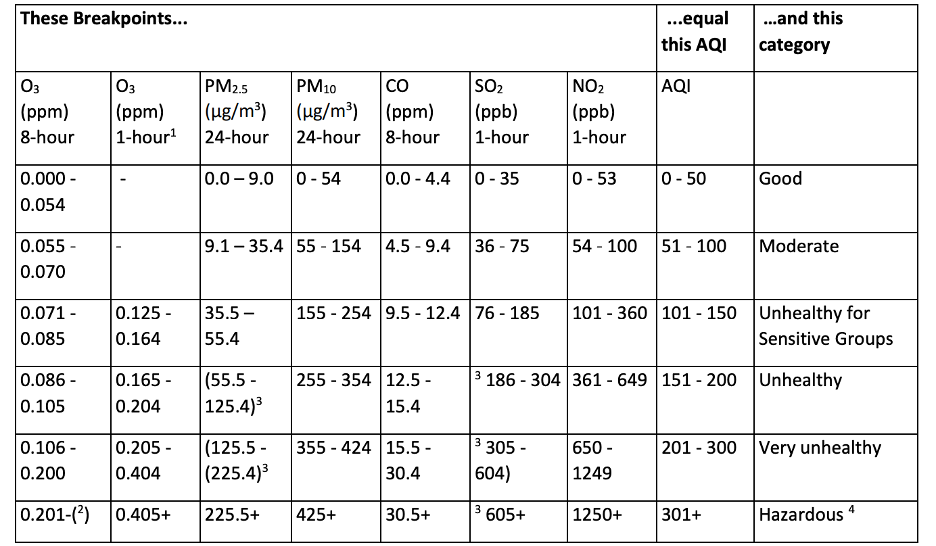

In [764]:
# Define breakpoints for pollutants based on EPA standards.
breakpoints_pm25 = [
    {'AQI_low': 0, 'AQI_high': 50, 'Conc_low': 0.0, 'Conc_high': 9.0},
    {'AQI_low': 51, 'AQI_high': 100, 'Conc_low': 9.1, 'Conc_high': 35.4},
    {'AQI_low': 101, 'AQI_high': 150, 'Conc_low': 35.5, 'Conc_high': 55.4},
    {'AQI_low': 151, 'AQI_high': 200, 'Conc_low': 55.5, 'Conc_high': 125.4},
    {'AQI_low': 201, 'AQI_high': 300, 'Conc_low': 125.5, 'Conc_high': 225.4},
    {'AQI_low': 301, 'AQI_high': 9999, 'Conc_low': 225.5, 'Conc_high': 9999}
]
breakpoints_pm10 = [
    {'AQI_low': 0, 'AQI_high': 50, 'Conc_low': 0, 'Conc_high': 54},
    {'AQI_low': 51, 'AQI_high': 100, 'Conc_low': 55, 'Conc_high': 154},
    {'AQI_low': 101, 'AQI_high': 150, 'Conc_low': 155, 'Conc_high': 254},
    {'AQI_low': 151, 'AQI_high': 200, 'Conc_low': 255, 'Conc_high': 354},
    {'AQI_low': 201, 'AQI_high': 300, 'Conc_low': 355, 'Conc_high': 424},
    {'AQI_low': 301, 'AQI_high': 9999, 'Conc_low': 425, 'Conc_high': 9999}
]
breakpoints_co = [
    {'AQI_low': 0, 'AQI_high': 50, 'Conc_low': 0.0, 'Conc_high': 4.4},
    {'AQI_low': 51, 'AQI_high': 100, 'Conc_low': 4.5, 'Conc_high': 9.4},
    {'AQI_low': 101, 'AQI_high': 150, 'Conc_low': 9.5, 'Conc_high': 12.4},
    {'AQI_low': 151, 'AQI_high': 200, 'Conc_low': 12.5, 'Conc_high': 15.4},
    {'AQI_low': 201, 'AQI_high': 300, 'Conc_low': 15.5, 'Conc_high': 30.4},
    {'AQI_low': 301, 'AQI_high': 9999, 'Conc_low': 30.5, 'Conc_high': 9999}
]
breakpoints_so2 = [
    {'AQI_low': 0, 'AQI_high': 50, 'Conc_low': 0, 'Conc_high': 35},
    {'AQI_low': 51, 'AQI_high': 100, 'Conc_low': 36, 'Conc_high': 75},
    {'AQI_low': 101, 'AQI_high': 150, 'Conc_low': 76, 'Conc_high': 185},
    {'AQI_low': 151, 'AQI_high': 200, 'Conc_low': 186, 'Conc_high': 304},
    {'AQI_low': 201, 'AQI_high': 300, 'Conc_low': 305, 'Conc_high': 604},
    {'AQI_low': 301, 'AQI_high': 9999, 'Conc_low': 605, 'Conc_high': 9999}
]
breakpoints_no2 = [
    {'AQI_low': 0, 'AQI_high': 50, 'Conc_low': 0, 'Conc_high': 53},
    {'AQI_low': 51, 'AQI_high': 100, 'Conc_low': 54, 'Conc_high': 100},
    {'AQI_low': 101, 'AQI_high': 150, 'Conc_low': 101, 'Conc_high': 360},
    {'AQI_low': 151, 'AQI_high': 200, 'Conc_low': 361, 'Conc_high': 649},
    {'AQI_low': 201, 'AQI_high': 300, 'Conc_low': 650, 'Conc_high': 1249},
    {'AQI_low': 301, 'AQI_high': 9999, 'Conc_low': 1250, 'Conc_high': 9999}
]
breakpoints_o3 = [
    {'AQI_low': 0, 'AQI_high': 50, 'Conc_low': 0.0, 'Conc_high': 0.054},
    {'AQI_low': 51, 'AQI_high': 100, 'Conc_low': 0.055, 'Conc_high': 0.070},
    {'AQI_low': 101, 'AQI_high': 150, 'Conc_low': 0.071, 'Conc_high': 0.085},
    {'AQI_low': 151, 'AQI_high': 200, 'Conc_low': 0.086, 'Conc_high': 0.105},
    {'AQI_low': 201, 'AQI_high': 300, 'Conc_low': 0.106, 'Conc_high': 0.200},
    {'AQI_low': 301, 'AQI_high': 9999, 'Conc_low': 0.201, 'Conc_high': 9999.000}
]


def calc_single_aqi(concentration, breakpoints):
    for bp in breakpoints:
        if bp['Conc_low'] <= concentration <= bp['Conc_high']:
            aqi_low, aqi_high = bp['AQI_low'], bp['AQI_high']
            conc_low, conc_high = bp['Conc_low'], bp['Conc_high']
            aqi = ((aqi_high - aqi_low) / (conc_high - conc_low)) * (concentration - conc_low) + aqi_low
            return round(aqi)
    return None  # Out of range

# 确保value在0和9999之间
def clamp(value):
    return max(0, min(9999, value))

def calculate_aqi(pollutants):
    if all(value is None for value in pollutants.values()):
        raise ValueError(f"All parameters are NONE, can NOT calc AQI.")
    # Calculate AQI for each pollutant.
    aqi_results = {}
    for pollutant, concentration in pollutants.items():
        #concentration = None if math.isnan(concentration) else concentration    # 去除 nan
        concentration = None if concentration is None else clamp(concentration) # 约束参数范围
        if pollutant == 'pm25' and not concentration is None:
            concentration = round(concentration, 1)     # 保留小数点
            aqi_results[pollutant] = calc_single_aqi(concentration, breakpoints_pm25)
        elif pollutant == 'pm10' and not concentration is None:
            concentration = round(concentration)
            aqi_results[pollutant] = calc_single_aqi(concentration, breakpoints_pm10)
        elif pollutant == 'co' and not concentration is None:
            concentration = round(concentration, 1)
            aqi_results[pollutant] = calc_single_aqi(concentration, breakpoints_co)
        elif pollutant == 'so2' and not concentration is None:
            concentration = round(concentration)
            aqi_results[pollutant] = calc_single_aqi(concentration, breakpoints_so2)
        elif pollutant == 'no2' and not concentration is None:
            concentration = round(concentration)
            aqi_results[pollutant] = calc_single_aqi(concentration, breakpoints_no2)
        elif pollutant == 'o3' and not concentration is None:
            concentration = round(concentration, 3)
            aqi_results[pollutant] = calc_single_aqi(concentration, breakpoints_o3)
    # print("--->>", pollutants)
    # print("===>>", aqi_results)
    return max(value for value in aqi_results.values() if value is not None)

In [766]:
# 保存目录
data_dir = './dataset'

for city in openAqLocation.keys():
    merged1_csv = f'./dataset/{city}_merged1.csv'
    merged1_df = pd.read_csv(merged1_csv)
    # 追加AQI
    merged1_df['AQI'] = merged1_df.apply(lambda row: calculate_aqi({
        'pm25': row.get('pm25', 0),
        'pm10': row.get('pm10', 0),
        'co':   row.get('co', 0),
        'so2':  row.get('so2', 0),
        'no2':  row.get('no2', 0),
        'o3':   row.get('o3', 0)
    }), axis=1)
    assert merged1_df['AQI'].isna().sum() == 0, "AQI calcuate error."
    # 保存
    merged1_df.to_csv(f'{data_dir}/{city}_merged2.csv', index=False)
    print(f'Added AQI for {city} to {data_dir}/{city}_merged2.csv')

Added AQI for 06249099999 to ./dataset/06249099999_merged2.csv
Added AQI for 44291099999 to ./dataset/44291099999_merged2.csv
Added AQI for 85682099999 to ./dataset/85682099999_merged2.csv
Added AQI for 72365023050 to ./dataset/72365023050_merged2.csv
Added AQI for 03680099999 to ./dataset/03680099999_merged2.csv
Added AQI for 99769299999 to ./dataset/99769299999_merged2.csv
Added AQI for 71172099999 to ./dataset/71172099999_merged2.csv
Added AQI for 72434013994 to ./dataset/72434013994_merged2.csv
Added AQI for 72243012960 to ./dataset/72243012960_merged2.csv
Added AQI for 71736599999 to ./dataset/71736599999_merged2.csv


In [767]:
# 查看文件
!ls -l ./dataset/*_merged2.csv

-rw-r--r--@ 1 ArthurLiu  staff  117186 Nov 27 23:45 ./dataset/03680099999_merged2.csv
-rw-r--r--@ 1 ArthurLiu  staff  321220 Nov 27 23:45 ./dataset/06249099999_merged2.csv
-rw-r--r--@ 1 ArthurLiu  staff  136229 Nov 27 23:45 ./dataset/44291099999_merged2.csv
-rw-r--r--@ 1 ArthurLiu  staff  312219 Nov 27 23:45 ./dataset/71172099999_merged2.csv
-rw-r--r--@ 1 ArthurLiu  staff  317822 Nov 27 23:45 ./dataset/71736599999_merged2.csv
-rw-r--r--@ 1 ArthurLiu  staff  383852 Nov 27 23:45 ./dataset/72243012960_merged2.csv
-rw-r--r--@ 1 ArthurLiu  staff  503099 Nov 27 23:45 ./dataset/72365023050_merged2.csv
-rw-r--r--@ 1 ArthurLiu  staff  423094 Nov 27 23:45 ./dataset/72434013994_merged2.csv
-rw-r--r--@ 1 ArthurLiu  staff  400286 Nov 27 23:45 ./dataset/85682099999_merged2.csv
-rw-r--r--@ 1 ArthurLiu  staff  167889 Nov 27 23:45 ./dataset/99769299999_merged2.csv


### 1.4 数据集成

将分离的数据集成为一个dataset

In [770]:
# 保存目录
data_dir = './dataset'
output_file = 'merged.csv'

# 创建一个空DataFrame
merged_df = pd.DataFrame()

for city in openAqLocation.keys():
    single_csv = f'./dataset/{city}_merged2.csv'
    single_df = pd.read_csv(single_csv)
    merged_df = pd.concat([merged_df, single_df], ignore_index=True)
    print("Merged single csv: ", single_csv)
    
# 添加自增长列
merged_df.insert(0, 'id', range(1, len(merged_df) + 1))
# 保存
merged_df.to_csv(f'{data_dir}/{output_file}', index=False)
print(f"{data_dir} *_merged2.csv files have been merged into {data_dir}/{output_file}.")


Merged single csv:  ./dataset/06249099999_merged2.csv
Merged single csv:  ./dataset/44291099999_merged2.csv
Merged single csv:  ./dataset/85682099999_merged2.csv
Merged single csv:  ./dataset/72365023050_merged2.csv
Merged single csv:  ./dataset/03680099999_merged2.csv
Merged single csv:  ./dataset/99769299999_merged2.csv
Merged single csv:  ./dataset/71172099999_merged2.csv
Merged single csv:  ./dataset/72434013994_merged2.csv
Merged single csv:  ./dataset/72243012960_merged2.csv
Merged single csv:  ./dataset/71736599999_merged2.csv
./dataset *_merged2.csv files have been merged into ./dataset/merged.csv.


## 2. 数据EDA

对于采集回来的数据，大致分析一下数据的特点和可用性。

### 2.1 数据预览

In [6]:
data_file = './dataset/merged.csv'
df = pd.read_csv(data_file)
df.head()

,id,DATE,NAME,WDSP,DEWP,MAX,MIN,PRCP,pm25,pm10,co,so2,no2,o3,AQI
0,1,2016-01-30 00:00:00+00:00,"BERKHOUT, NL",22.1,42.0,50.2,41.2,0.2200,4.409171,7.535681,0.001,0.0009,0.0004,0.0005,24
1,2,2016-01-31 00:00:00+00:00,"BERKHOUT, NL",11.7,40.9,47.8,39.9,0.2400,3.566010,8.520501,0.001,0.0009,0.0004,2.0000,303
2,3,2016-02-01 00:00:00+00:00,"BERKHOUT, NL",20.6,48.2,52.3,42.6,0.1600,5.846396,9.621782,0.001,0.0009,0.0004,0.0005,32
3,4,2016-02-02 00:00:00+00:00,"BERKHOUT, NL",21.2,37.0,50.2,43.2,0.0004,9.271362,18.961972,80.000,0.0009,0.0004,2.0000,349
4,5,2016-02-03 00:00:00+00:00,"BERKHOUT, NL",13.1,35.1,44.8,35.2,0.0004,5.921347,14.278759,80.000,0.0009,0.0004,2.0000,349


### 2.2 各指标的数据分布

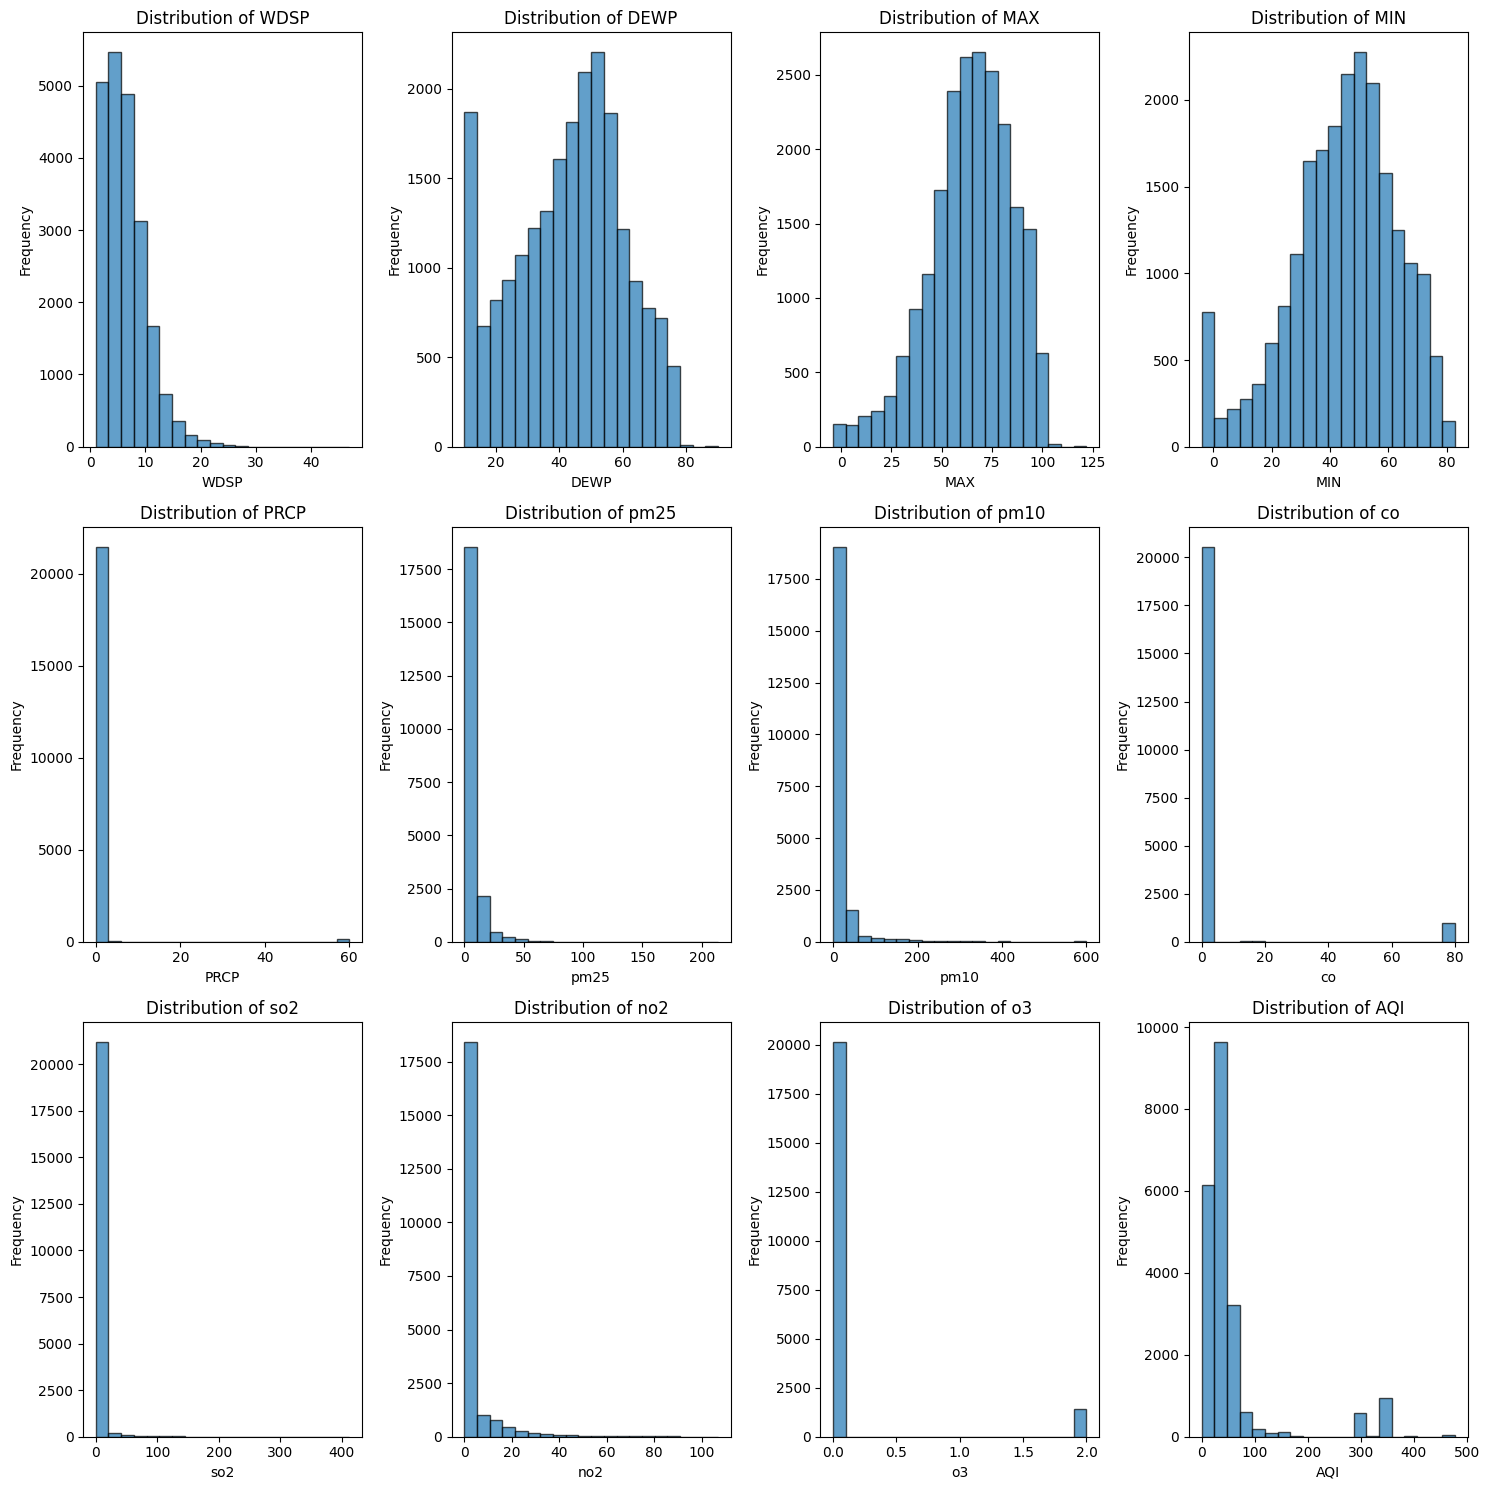

In [9]:
# 绘制直方图
variables = ['WDSP', 'DEWP', 'MAX', 'MIN', 'PRCP', 'pm25', 'pm10', 'co', 'so2', 'no2', 'o3', 'AQI']
ncols = 4
nrows = (len(variables) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))
axes = axes.flatten()  # Flatten the axes array to make it 1D for easy iteration

for i, var in enumerate(variables):
    ax = axes[i]
    ax.hist(df[var], bins=20, alpha=0.7, edgecolor='black')
    ax.set_title(f'Distribution of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 2.3 AQI与各个污染物之间的关系

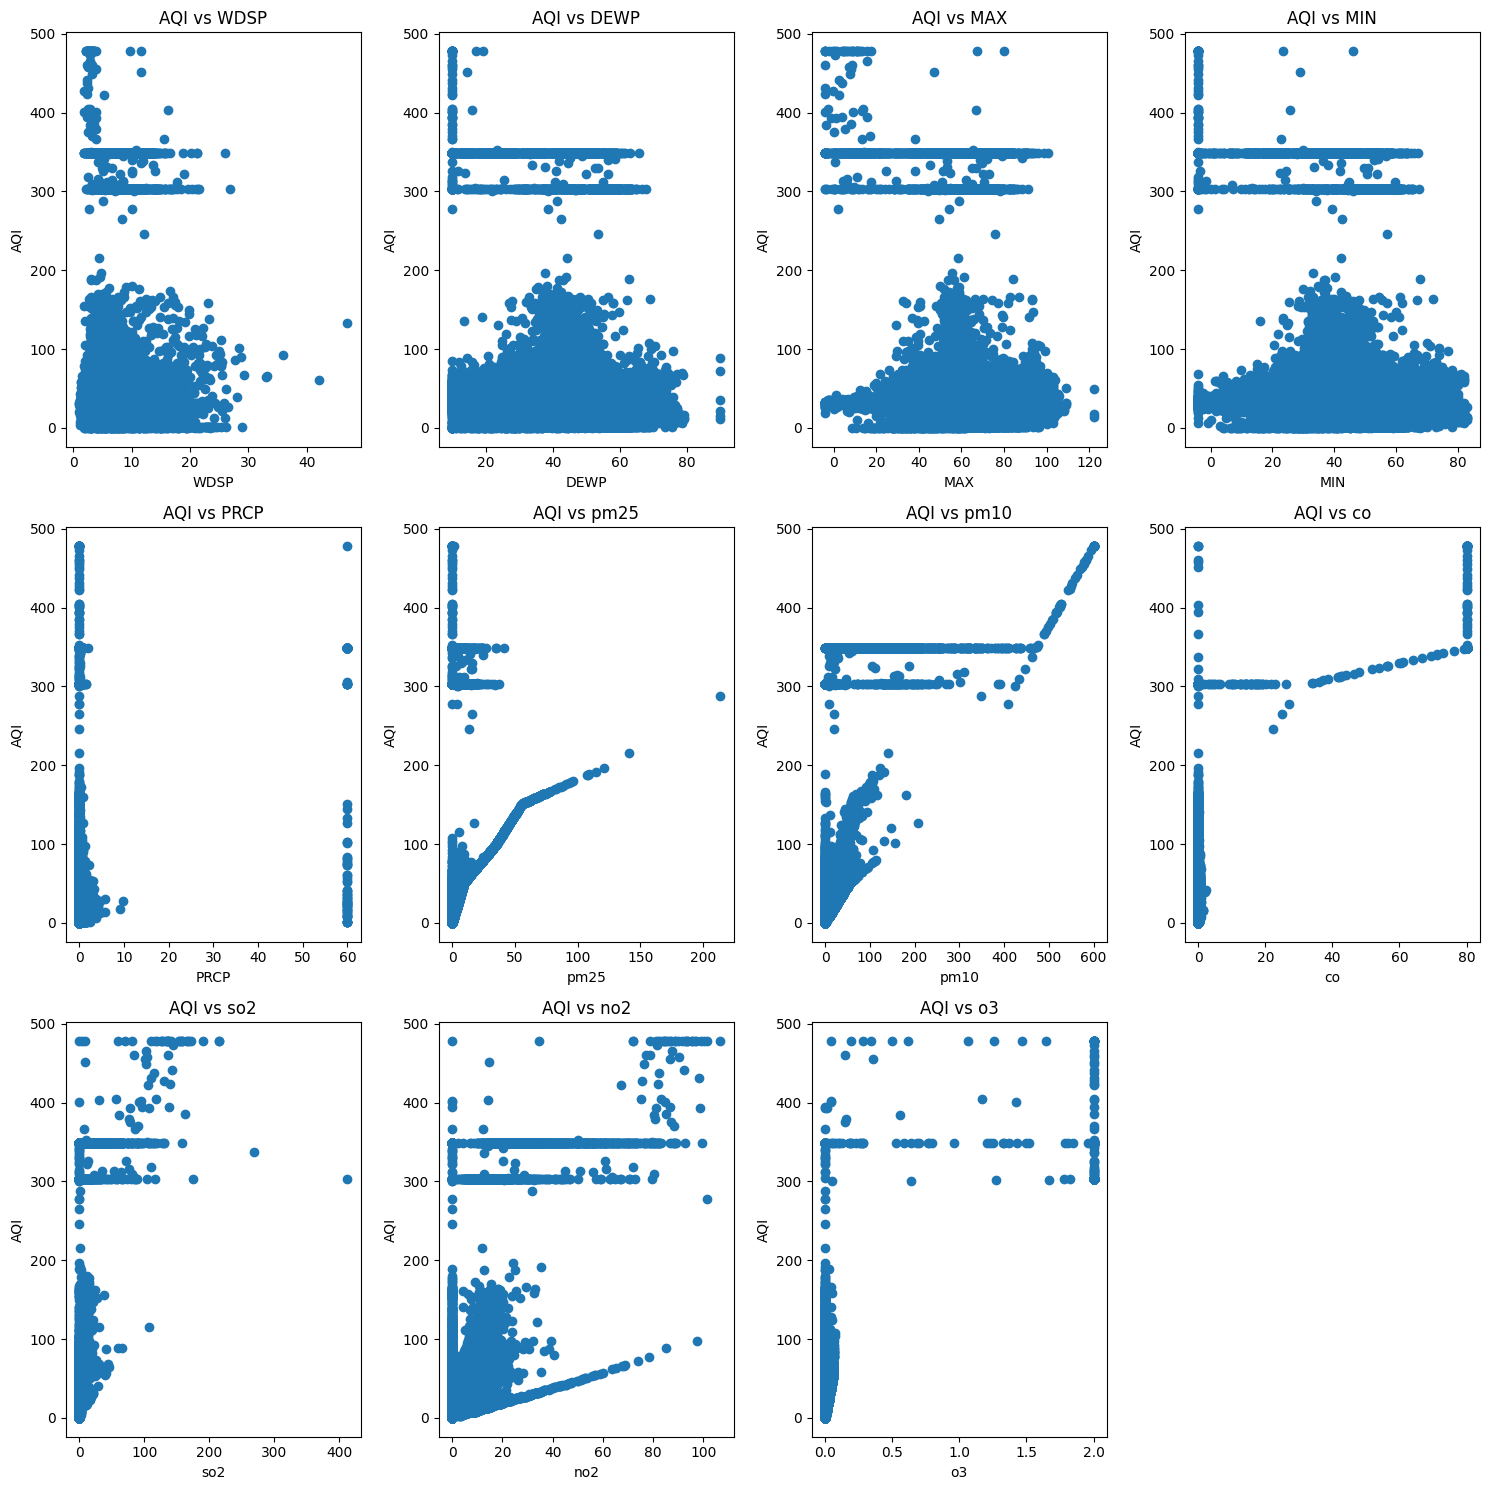

In [10]:
# 污染物列表
pollutants = ['WDSP', 'DEWP', 'MAX', 'MIN', 'PRCP', 'pm25', 'pm10', 'co', 'so2', 'no2', 'o3']

# 每行3幅图
ncols = 4
nrows = (len(pollutants) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))
axes = axes.flatten()  # Flatten the axes array to make it 1D for easy iteration

for i, pollutant in enumerate(pollutants):
    ax = axes[i]
    ax.scatter(df[pollutant], df['AQI'])
    ax.set_title(f'AQI vs {pollutant}')
    ax.set_xlabel(pollutant)
    ax.set_ylabel('AQI')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 2.4 不同污染物的分布箱线图

<Figure size 1200x800 with 0 Axes>

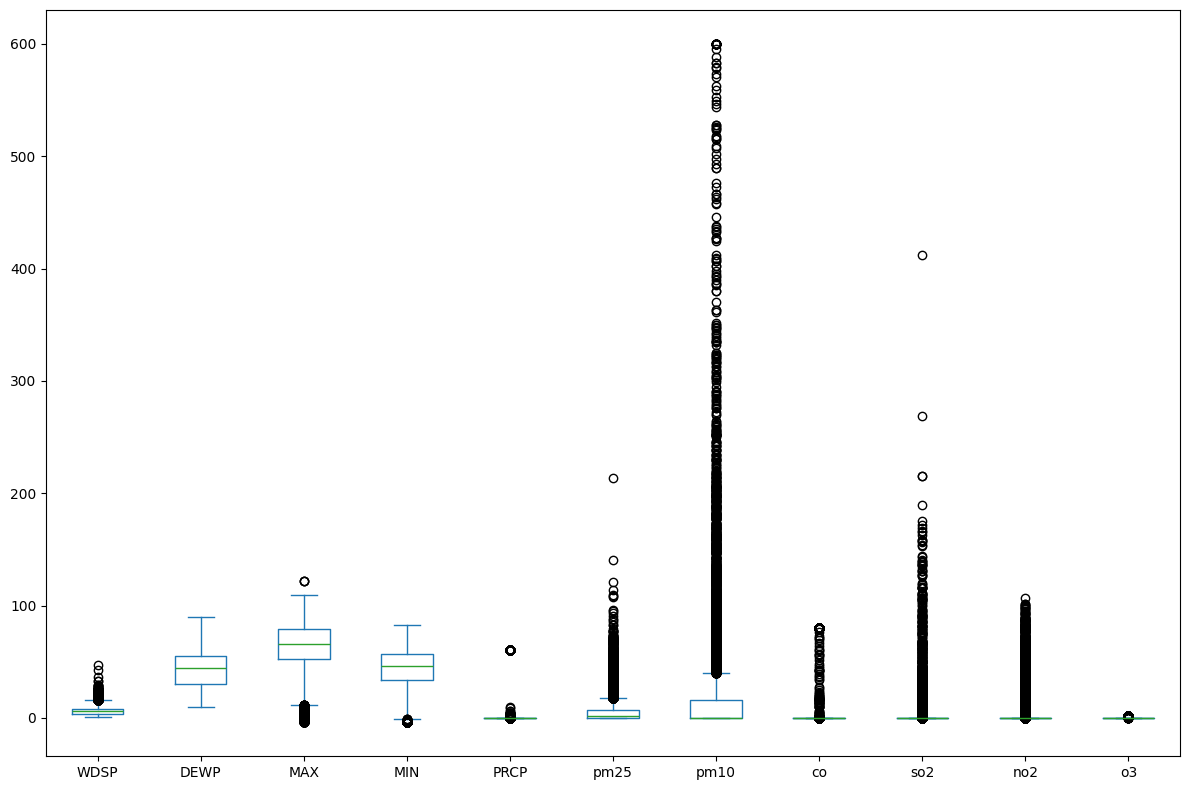

In [955]:
# 箱线图展示
plt.figure(figsize=(12, 8))
df[['WDSP', 'DEWP', 'MAX', 'MIN', 'PRCP', 'pm25', 'pm10', 'co', 'so2', 'no2', 'o3']].plot(kind='box', layout=(3, 4), figsize=(12, 8))
plt.tight_layout()
plt.show()

## 3. 模型训练与评估

对于采集清洗过的数据，基于 AutoGluon 的 TimeSeries 包进行时间序列训练。

### 3.1 时间序列训练

用前3天序列数据推导第4天的AQI

In [963]:

# 训练数据
data_file = './dataset/merged.csv'
model_save_path = './AutogluonModels/Liam'

data = pd.read_csv(data_file)

# 格式化为 AutoGluon TimeSeries 所需的格式
# 必须包含以下列：
# - `item_id`: 唯一标识每个时间序列（如地点、站点）。如果只有一个序列，可以用常数填充。
# - `timestamp`: 日期时间列。
# - `target`: 需要预测的目标变量。
num_rows = len(data)
date_range = pd.date_range(start='1960-01-01', periods=num_rows, freq='D')
data['timestamp'] = date_range                  # 添加日期序列，从1960年1月1日开始，每行增加一天
data = data.rename(columns={'AQI': 'target'})   # 字段改名
data['item_id'] = 'default'                     # 添加字段

# 选择需要的列（预测变量和目标变量）
formatted_data = data[['item_id', 'timestamp', 'target', 
    'DEWP', 'WDSP', 'MAX', 'MIN', 'PRCP', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]

# 划分训练和测试集
train_data = formatted_data[formatted_data['timestamp'] < '2007-01-01'] # 17167/21608, 约80%
test_data = formatted_data[formatted_data['timestamp'] >= '2007-01-01']

# 转化为 TimeSeriesDataFrame
train_data = TimeSeriesDataFrame.from_data_frame(
    train_data,
    id_column='item_id',         # 指定唯一标识列
    timestamp_column='timestamp' # 指定时间戳列
)
test_data = TimeSeriesDataFrame.from_data_frame(
    test_data,
    id_column='item_id',         # 指定唯一标识列
    timestamp_column='timestamp' # 指定时间戳列
)

# 创建 TimeSeriesPredictor
predictor = TimeSeriesPredictor(
    target="target",        # 目标列
    prediction_length=1,    # 预测步长，这里为下一天的 AQI
    path=model_save_path,   # 模型保存路径
    # lags=3,               # 使用前3天的数据作为输入
    eval_metric="MASE",     # 评估指标，可以是 MAE、RMSE 等
)

# 训练模型
predictor.fit(
    train_data=train_data, 
    #presets="medium_quality", 
    time_limit=600      # 设置训练时间限制（单位：秒）, 10分钟
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to './AutogluonModels/Liam'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:12:58 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T6000
CPU Count:          8
GPU Count:          0
Memory Avail:       0.73 GB / 16.00 GB (4.6%)
Disk Space Avail:   82.85 GB / 460.43 GB (18.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 1

### 3.2 预测评估

评估 AutoGluon 训练出的各个模型的性能。

In [964]:
# 预测下一天的 AQI
forecast = predictor.predict(test_data)

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


In [965]:
forecast

,,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
item_id,timestamp,,,,,,,,,,
default,2019-02-28,19.789515,14.353069,16.143297,17.259901,18.693213,19.789515,21.235655,23.01388,24.493546,27.161589


In [966]:
# 模型评估
evaluation_results = predictor.evaluate(test_data)
print("Evaluation Results:", evaluation_results)

Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


Evaluation Results: {'MASE': -0.10538720932977189}


In [967]:
# 列出所有模型
all_models = predictor.get_model_names()
print("已训练模型:", all_models)

已训练模型: ['RecursiveTabular', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST', 'WeightedEnsemble']


/var/folders/m6/746w29hs661_9_b1cptnrjwr0000gq/T/ipykernel_93566/3770413411.py:2: DeprecationWarning: `get_model_names` has been deprecated and will be removed in version 1.2. Please use `model_names` instead. This will raise an error in the future!
  all_models = predictor.get_model_names()


In [968]:
# 获取 leaderboard 数据
leaderboard = predictor.leaderboard(test_data)
leaderboard

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-0.091081,-0.207955,0.021548,0.024227,61.518556,4
1,WeightedEnsemble,-0.105387,-0.016337,0.060331,0.061715,0.119356,5
2,TemporalFusionTransformer,-0.105387,-0.016337,0.059355,0.061715,129.448152,2
3,DeepAR,-0.163874,-0.286369,0.020213,0.020618,86.668069,3
4,RecursiveTabular,-0.331696,-0.233704,0.042682,0.076040,13.253849,1


In [969]:
# 获取最佳模型，默认是 score_val 得分最低的，即在验证集上效果最好的
best_model = predictor.get_model_best()
print(f"最佳模型是: {best_model}")

最佳模型是: TemporalFusionTransformer


/var/folders/m6/746w29hs661_9_b1cptnrjwr0000gq/T/ipykernel_93566/2026941788.py:2: DeprecationWarning: `get_model_best` has been deprecated and will be removed in version 1.2. Please use `model_best` instead. This will raise an error in the future!
  best_model = predictor.get_model_best()


In [970]:
# 测试集分数最优的模型
best_test_model = leaderboard.loc[leaderboard['score_test'].idxmax(), 'model']
print(f"测试集上表现最好的模型是: {best_test_model}")

测试集上表现最好的模型是: PatchTST


In [971]:
# 获取模型存储路径
predictor._trainer.path

'./AutogluonModels/Liam/models'

In [973]:
!ls -l ./AutogluonModels/Liam/models

total 24
drwxr-xr-x@ 5 ArthurLiu  staff   160 Nov 28 14:32 DeepAR
drwxr-xr-x@ 3 ArthurLiu  staff    96 Nov 28 14:14 DirectTabular
drwxr-xr-x@ 5 ArthurLiu  staff   160 Nov 28 14:33 PatchTST
drwxr-xr-x@ 5 ArthurLiu  staff   160 Nov 28 14:28 RecursiveTabular
drwxr-xr-x@ 5 ArthurLiu  staff   160 Nov 28 14:16 TemporalFusionTransformer
drwxr-xr-x@ 3 ArthurLiu  staff    96 Nov 28 14:33 WeightedEnsemble
-rw-r--r--@ 1 ArthurLiu  staff  5140 Nov 28 23:43 cached_predictions.pkl
-rw-r--r--@ 1 ArthurLiu  staff  2201 Nov 28 23:42 trainer.pkl


## 4. 模型推理

对于 AutoGluon 训练出的模型，选择其中比较适合的，进行推理应用。

### 4.1 选择模型

In [849]:
# 加载 predictor
predictor = TimeSeriesPredictor.load("AutogluonModels/Liam/")

# 选择模型
predictions = predictor.predict(test_data, model="DeepAR")
predictions

,,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
item_id,timestamp,,,,,,,,,,
default,2019-02-28,16.414415,11.365237,13.035661,14.522765,15.774579,16.457082,17.563665,18.267599,19.447177,21.363218


### 4.2 Model Inference

In [975]:
# 推理函数：根据输入日期，进行 AQI 预测
def predict_aqi(input_date, data, predictor):
    # 确保输入日期为 pandas 的 datetime 格式
    input_date = pd.to_datetime(input_date)

    # 确认是否有足够的历史数据
    start_date = input_date - pd.Timedelta(days=3)
    if start_date not in data['timestamp'].values:
        raise ValueError("历史数据不足，无法预测，请确保输入日期的前3天有数据")

    # 提取前3天的历史数据
    history_data = data[(data['timestamp'] >= start_date) & (data['timestamp'] < input_date)]
    if len(history_data) != 3:
        raise ValueError("前3天的历史数据不完整，无法预测")

    # 构造预测输入
    # 注意：TimeSeriesDataFrame 需要目标值，即使是 NaN，也要在预测时指定
    future_date = pd.DataFrame({
        'timestamp': [input_date],
        'AQI': [None]  # 占位
    })
    prediction_input = pd.concat([history_data, future_date], ignore_index=True)
    
    # 字段改名
    prediction_input = prediction_input.rename(columns={'AQI': 'target'})
    prediction_input['item_id'] = 'default'

    # 转换为 TimeSeriesDataFrame 格式
    prediction_input = TimeSeriesDataFrame.from_data_frame(
        prediction_input,
        timestamp_column='timestamp',
        #target_column='AQI'
    )

    # 使用模型进行预测
    predictions = predictor.predict(prediction_input)

    # 获取预测值
    predicted_mean = predictions['mean'].iloc[0]
    predicted_quantiles = predictions.iloc[0, 3:]  # 获取不确定性区间

    return {
        "predicted_mean": predicted_mean,
        "quantiles": predicted_quantiles.to_dict()
    }

In [976]:
# 模型路径
model_path = 'AutogluonModels/Liam/'

# 加载训练好的模型
predictor = TimeSeriesPredictor.load(model_path)

# 完整的时间序列数据，data 包括所有历史特征
data = pd.read_csv("./dataset/test_2019.csv")
# data['datetime'] = pd.to_datetime(data['datetime'])
# data = data.sort_values(['datetime'])  # 按时间排序

num_rows = len(data)
# 生成一个日期序列，行增加一天，直到df的行数
date_range = pd.date_range(start='2019-01-02', periods=num_rows, freq='D')
data['timestamp'] = date_range
# 取3天的作为测试数据
data_subset = data.head(3)

# 示例调用
input_date = "2019-01-05" #预测日期
result = predict_aqi(input_date, data_subset, predictor)
print(f"预测日期 {input_date} 的 AQI 值为: {result['predicted_mean']:.2f}")
print(f"不确定性区间为: {result['quantiles']}")

Loading predictor from path AutogluonModels/Liam/
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer


预测日期 2019-01-05 的 AQI 值为: 27.53
不确定性区间为: {'0.3': 26.590282440185547, '0.4': 26.957555770874023, '0.5': 27.527233123779297, '0.6': 27.391170501708984, '0.7': 28.021175384521484, '0.8': 28.69389533996582, '0.9': 28.950754165649414}
